In [1]:
import os
import cv2
import glob as gb
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf 
from matplotlib import cm
from random import shuffle
import matplotlib.pyplot as plt

from keras.models import load_model

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tf_keras_vis.utils import normalize
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.saliency import Saliency

from keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import warnings


for dirname, _, filenames in os.walk('.\input\datafinal'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\input\datafinal\test\covid\Covid (92).jpeg
.\input\datafinal\test\covid\Covid (92).jpg
.\input\datafinal\test\covid\Covid (92).png
.\input\datafinal\test\covid\Covid (93).jpeg
.\input\datafinal\test\covid\Covid (93).jpg
.\input\datafinal\test\covid\Covid (93).png
.\input\datafinal\test\covid\Covid (94).jpeg
.\input\datafinal\test\covid\Covid (94).jpg
.\input\datafinal\test\covid\Covid (94).png
.\input\datafinal\test\covid\Covid (95).jpeg
.\input\datafinal\test\covid\Covid (95).jpg
.\input\datafinal\test\covid\Covid (95).png
.\input\datafinal\test\covid\Covid (96).jpeg
.\input\datafinal\test\covid\Covid (96).jpg
.\input\datafinal\test\covid\Covid (96).png
.\input\datafinal\test\covid\COVID19_460_.jpeg
.\input\datafinal\test\covid\COVID19_461_.jpeg
.\input\datafinal\test\covid\COVID19_462_.jpeg
.\input\datafinal\test\covid\COVID19_463_.jpeg
.\input\datafinal\test\covid\COVID19_464_.jpeg
.\input\datafinal\test\covid\COVID19_465_.jpeg
.\input\datafinal\test\covid\COVID19_466_.jpeg
.\inpu

In [2]:
TrianImage="input/datafinal/train"
TestImage="input/datafinal/test"

In [3]:
Normalimages = os.listdir(TrianImage + "/normal")
COVID19images = os.listdir(TrianImage + "/covid")

## Dataset Overview

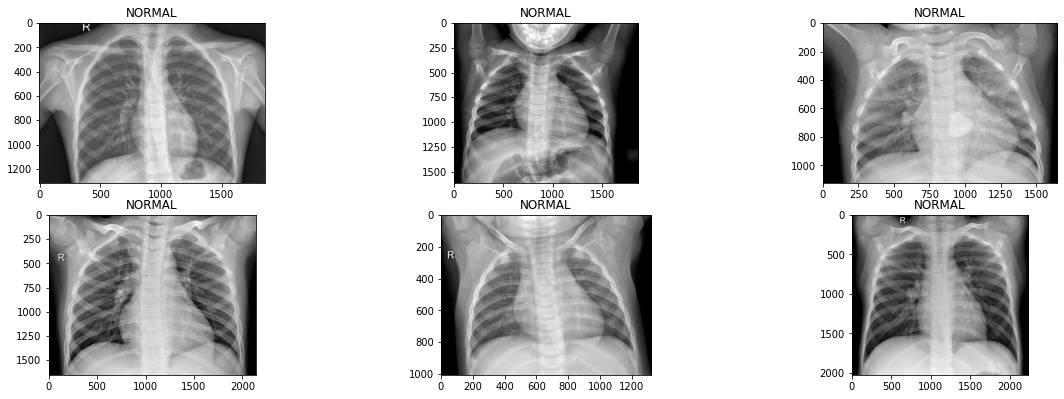

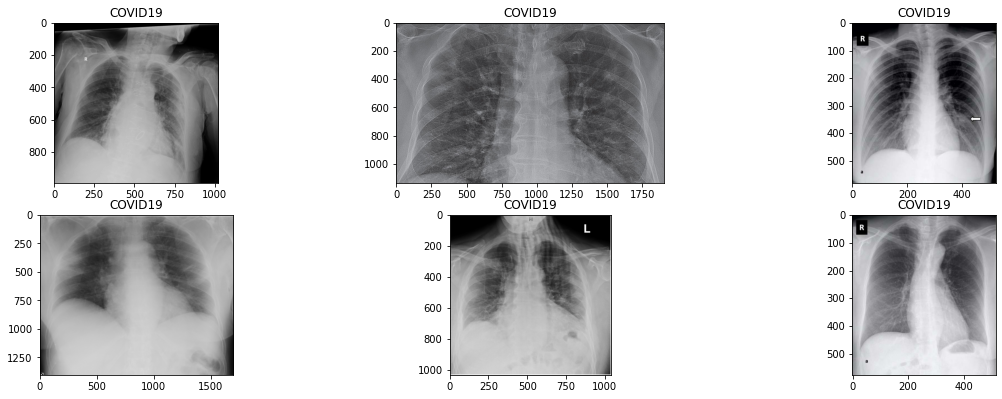

In [4]:
#plot NORMAL Images
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/normal",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()
#plot Covid-19 Images
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/covid",COVID19images[i])),cmap='gray')
    plt.title("COVID19")
plt.show()

# ImageDataGenerator (DataAugmentation-Preprocessing)

In [5]:
BATCH_SIZE = 50
sizeImage=300
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      fill_mode='nearest'
                                  )

train_generator =train_datagen.flow_from_directory(
     TrianImage,
     batch_size= BATCH_SIZE,
     shuffle=shuffle,
     target_size=(sizeImage, sizeImage)

)

test_generator =train_datagen.flow_from_directory(
     TestImage,
     batch_size= BATCH_SIZE,
     shuffle=shuffle,
     target_size=(sizeImage, sizeImage)

)


Found 976 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [6]:
Labels={'normal':0,'covid':1}

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x

# Explore Data After DataAugmentation and standardizing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


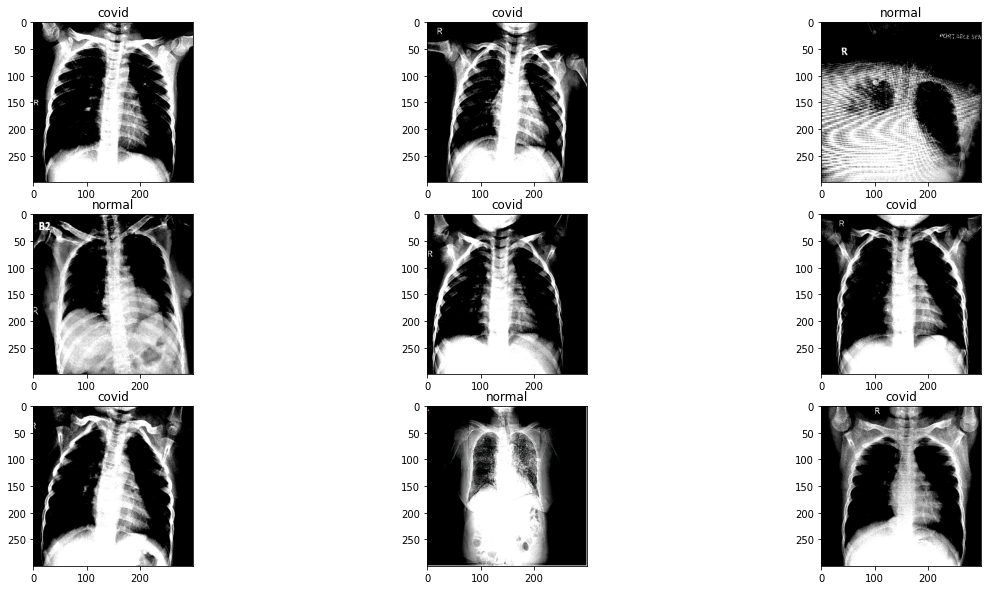

In [50]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_generator.__getitem__(0)[0][i])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(0)[1][i])) )

# Build Model

In [8]:
#load weight
Network_Weight="input/weight/DenseNet-BC-169-32-no-top.h5"

In [9]:
pre_trained_model = DenseNet169(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights
pre_trained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [10]:
x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)


x=tf.keras.layers.Dense(2 , activation='sigmoid')(x)
       

model = Model(pre_trained_model.input, x) 

print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [11]:
warnings.filterwarnings("ignore")
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
warnings.filterwarnings("ignore")
%%time
epochs = 15
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
                              validation_data=test_generator,
                              validation_steps=len(test_generator.filenames) // BATCH_SIZE,
                              callbacks=[lr_reduce,checkpoint],
                              epochs=epochs)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
19/19 [==============================] - 124s 7s/step - loss: 1.8843 - accuracy: 0.8898 - val_loss: 0.0874 - val_accuracy: 0.9933
Epoch 2/15
19/19 [==============================] - 119s 6s/step - loss: 0.1627 - accuracy: 0.9903 - val_loss: 0.2212 - val_accuracy: 0.9911
Epoch 3/15
19/19 [==============================] - 119s 6s/step - loss: 0.1018 - accuracy: 0.9957 - val_loss: 0.0178 - val_accuracy: 0.9978
Epoch 4/15
19/19 [==============================] - 119s 6s/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9956
Epoch 5/15
19/19 [==============================] - 120s 6s/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 6/15
19/19 [==============================] - 122s 6s/step - loss: 0.0100 - accuracy: 0.9989 - val_loss: 0.0860 - val_accuracy: 0.9956
Epoch 7/15
19/19 [==============================] - 119s 6s/step - loss: 0.016

# Evaluation

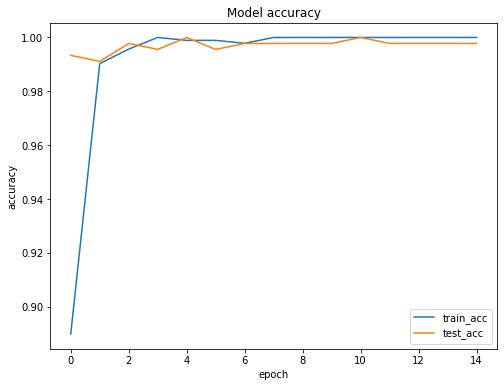

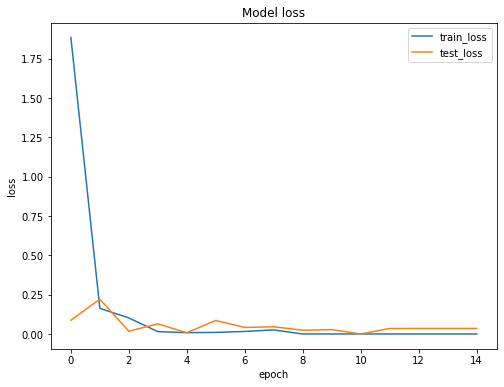

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'],label="train_acc")
plt.plot(history.history['val_accuracy'],label="test_acc")
plt.title('Model accuracy')
plt.ylabel('accuracy')
#plt.ylim(0.9,1)
plt.xlabel('epoch')
plt.legend(loc='best')
plt.savefig('Model accuracy.png')
plt.show()
# summarize history for loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'],label="train_loss")
plt.plot(history.history['val_loss'],label="test_loss")
#plt.ylim(0,2)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.savefig('Model loss.png')
plt.show()

In [14]:
#Evaluate Model
model.evaluate(test_generator)

10/10 [==============================] - 38s 4s/step - loss: 0.0328 - accuracy: 0.9979


[0.032840218394994736, 0.9979166388511658]

In [15]:
#model.save('DenseNet-Binary_no_pre.h5')

In [16]:
#prediction
warnings.filterwarnings("ignore")
pred=model.predict(test_generator)
DenseNetpred_gene = model.predict_generator(test_generator, steps = len(test_generator))

Instructions for updating:
Please use Model.predict, which supports generators.


In [17]:
y_test=[]
for i in range(10):
    y_test.extend(test_generator.__getitem__(i)[1])
y_test =np.array(y_test) 
y_score = DenseNetpred_gene 

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [19]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

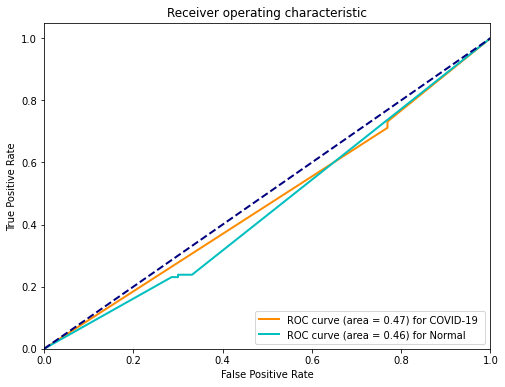

In [27]:
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) for COVID-19 ' % roc_auc[1])
plt.plot(fpr[0], tpr[0], color='c',
         lw=lw, label='ROC curve (area = %0.2f) for Normal' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Receiver operating characteristic.png')
plt.show()

In [21]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

Confusion Matrix


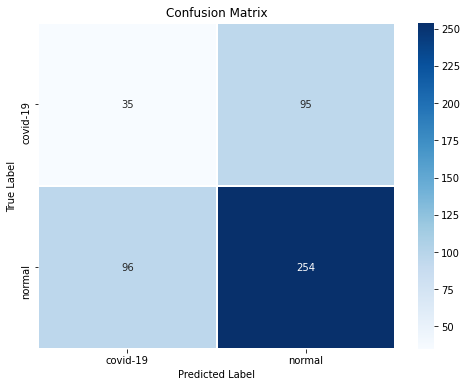

[[ 35  95]
 [ 96 254]]
Classification Report
              precision    recall  f1-score   support

    covid-19       0.27      0.27      0.27       130
      normal       0.73      0.73      0.73       350

    accuracy                           0.60       480
   macro avg       0.50      0.50      0.50       480
weighted avg       0.60      0.60      0.60       480



In [28]:
LABELS = ["covid-19","normal"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="Blues",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig('Confusion Matrix.png')
    plt.show()


print('Confusion Matrix')
show_confusion_matrix(y_test, pred)
print(confusion_matrix(y_test, pred))
print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(y_test, pred, target_names=target_names))

# Presenting the Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


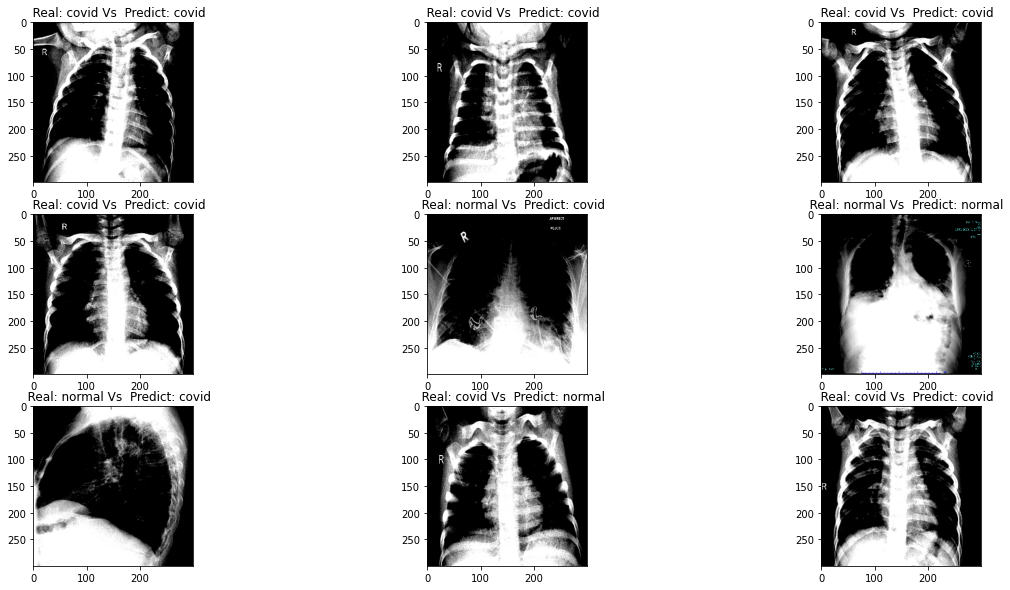

In [23]:
plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_generator.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")